<a href="https://colab.research.google.com/github/ldivrala/Loan-Eligibility-Predication/blob/main/LoanEligibilityPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
%matplotlib inline

Data Collection And Preprocessing

In [ ]:
loan_dataset = pd.read_csv("/content/train.csv")
loan_dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# Reduce Memory Usage
def reduce_memory_usage(df):
  start_mem = df.memory_usage().sum() / 1024 ** 2
  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()

      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
          df[col] = df[col].astype(np.float64)

  end_mem = df.memory_usage().sum() / 1024 ** 2
  print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df        

In [ ]:
loan_dataset = reduce_memory_usage(loan_dataset)

Memory usage of dataframe is 0.06 MB --> 0.05 MB (Decreased by 19.2%)


In [ ]:
loan_dataset.shape

(614, 13)

In [ ]:
loan_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int32  
 7   CoapplicantIncome  614 non-null    float32
 8   LoanAmount         592 non-null    float32
 9   Loan_Amount_Term   600 non-null    float32
 10  Credit_History     564 non-null    float32
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float32(4), int32(1), object(8)
memory usage: 50.5+ KB


In [ ]:
loan_dataset.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.000000,564.000000
mean,5403.459283,1621.245850,146.412155,342.000000,0.842199
std,6109.041673,2926.247314,85.587288,65.120415,0.364879
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


EDA

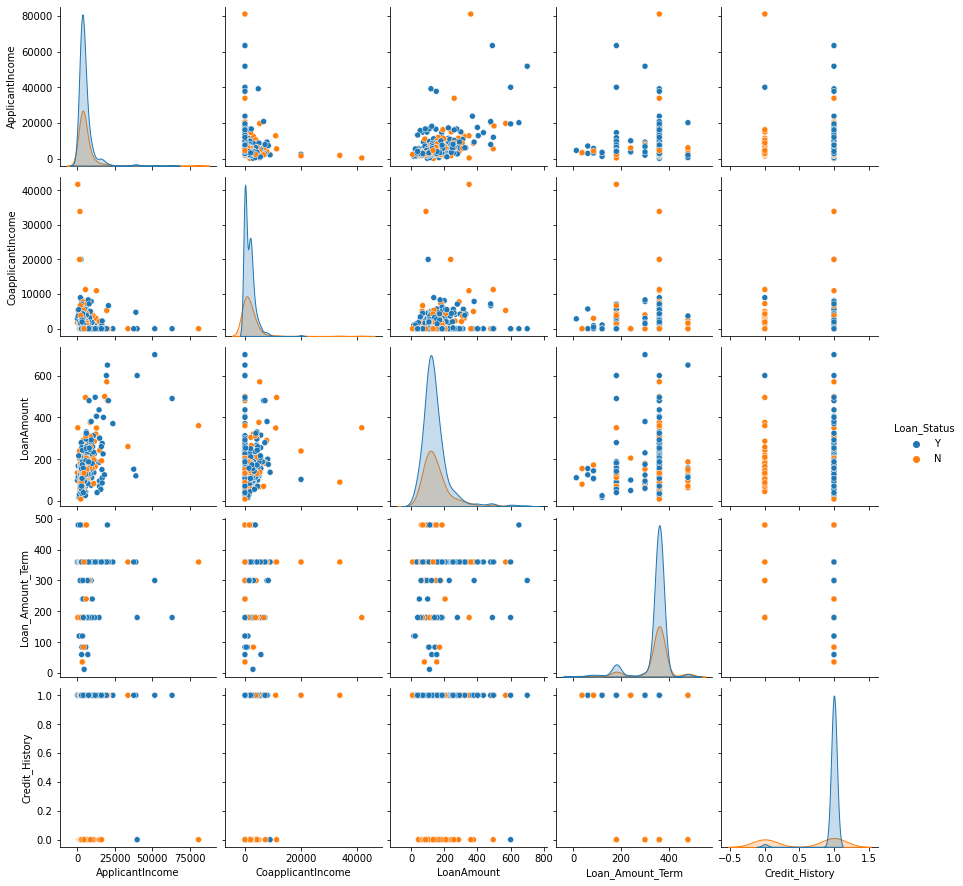

In [ ]:
sns.pairplot(loan_dataset, hue='Loan_Status')

In [ ]:
Categorical_features =[feature for feature in loan_dataset.columns if loan_dataset[feature].dtypes == 'object']
Categorical_features

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [ ]:
Categorical_features = Categorical_features[1:]

In [ ]:
Numerical_features=[feature for feature in loan_dataset.columns if loan_dataset[feature].dtypes != 'object']
Numerical_features

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [ ]:
Continous_features=[]
Discrete_features=[]

for feature in Numerical_features:
  print(f"Number of unique values in column {feature}: {loan_dataset[feature].nunique()}")

  if loan_dataset[feature].nunique() > 15:
    Continous_features.append(feature)

  else:
    Discrete_features.append(feature)

Number of unique values in column ApplicantIncome: 505
Number of unique values in column CoapplicantIncome: 287
Number of unique values in column LoanAmount: 203
Number of unique values in column Loan_Amount_Term: 10
Number of unique values in column Credit_History: 2


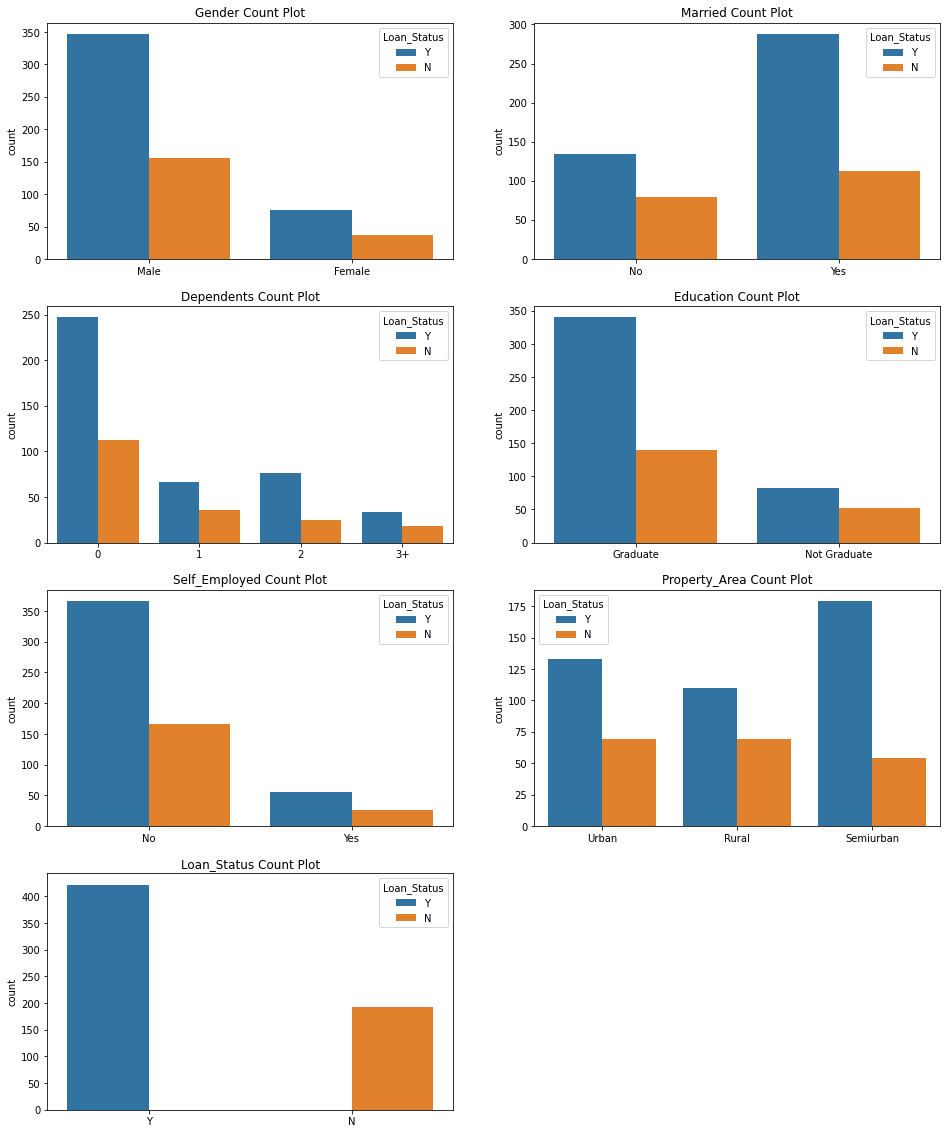

In [ ]:

# fig, _ = plt.subplots(len(Categorical_features)//2, len(Categorical_features)//2, sharey = True)

fig = plt.figure(figsize=(16, (len(Categorical_features)//2 + 1) * 5))
for i, feature in enumerate(Categorical_features):

  plt.subplot((len(Categorical_features)// 2 + 1) , 2, i+1)
  
  sns.countplot(data = loan_dataset, x =feature, hue = "Loan_Status")

  plt.title(f"{feature} Count Plot")
  plt.xlabel("")

plt.show()


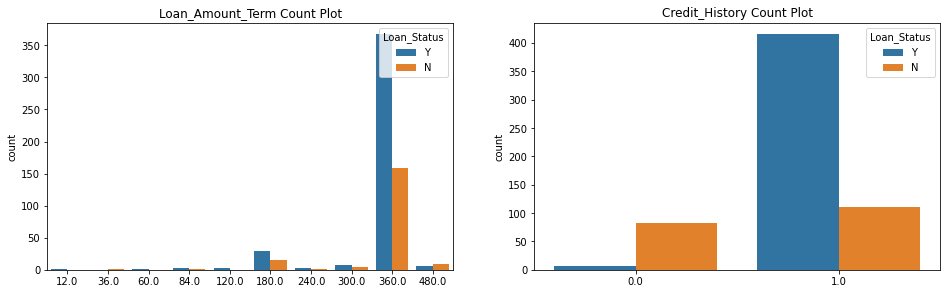

In [ ]:

fig = plt.figure(figsize=(16, (len(Discrete_features)//2 + 1) * 5))
for i, feature in enumerate(Discrete_features):
  plt.subplot((len(Discrete_features)//2 + 1), 2, i+1)

  sns.countplot(data = loan_dataset, x =feature, hue = "Loan_Status")

  plt.title(f"{feature} Count Plot")
  plt.xlabel("")

plt.show()

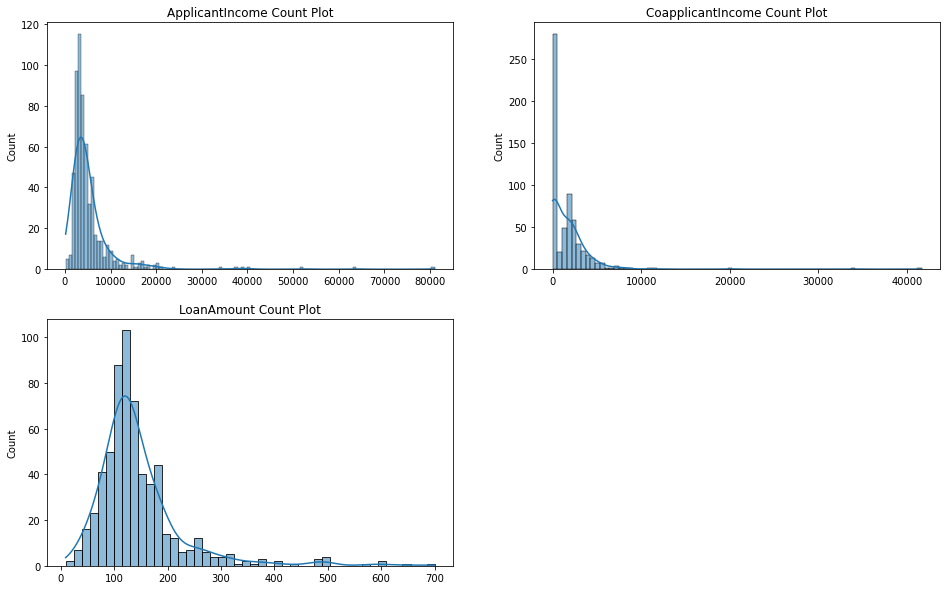

In [ ]:

fig = plt.figure(figsize=(16, (len(Continous_features)//2 + 1) * 5))
for i, feature in enumerate(Continous_features):

  plt.subplot((len(Continous_features)//2 + 1), 2, i+1)

  sns.histplot(loan_dataset[feature], kde = True)

  plt.title(f"{feature} Count Plot")

  plt.xlabel("")

plt.show()

Handling Missing Values

In [ ]:
# Missing value precentage
loan_dataset.isnull().sum() / loan_dataset.count() * 100

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

In [ ]:
# Handle Missing Value, Central Tendency
# Categorical values By MODE
preprocessing_tools["missing_values"] = {}

for feature in Categorical_features + Discrete_features:
  loan_dataset[feature].fillna(loan_dataset[feature].mode()[0], inplace = True)
  preprocessing_tools["missing_values"][feature] = loan_dataset[feature].mode()[0]

# Continous values, Median
for feature in Continous_features:
  loan_dataset[feature].fillna(loan_dataset[feature].median(skipna = True), inplace = True)
  preprocessing_tools["missing_values"][feature] = loan_dataset[feature].median(skipna = True)


In [ ]:
# Missing value precentage
loan_dataset.isnull().sum() / loan_dataset.count() * 100

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

In [ ]:
preprocessing_tools

{'missing_values': {'ApplicantIncome': 3812.5,
  'CoapplicantIncome': 1188.5,
  'Credit_History': 1.0,
  'Dependents': '0',
  'Education': 'Graduate',
  'Gender': 'Male',
  'LoanAmount': 128.0,
  'Loan_Amount_Term': 360.0,
  'Loan_Status': 'Y',
  'Married': 'Yes',
  'Property_Area': 'Semiurban',
  'Self_Employed': 'No'},
 'one_hot_replace': {'Credit_History': ({0.0: 1, 1.0: 0}, 2),
  'Dependents': ({'0': 0, '1': 1, '2': 2, '3+': 3}, 4),
  'Education': ({'Graduate': 0, 'Not Graduate': 1}, 2),
  'Gender': ({'Female': 1, 'Male': 0}, 2),
  'Loan_Status': ({'N': 1, 'Y': 0}, 2),
  'Married': ({'No': 0, 'Yes': 1}, 2),
  'Property_Area': ({'Rural': 1, 'Semiurban': 2, 'Urban': 0}, 3),
  'Self_Employed': ({'No': 0, 'Yes': 1}, 2)}}

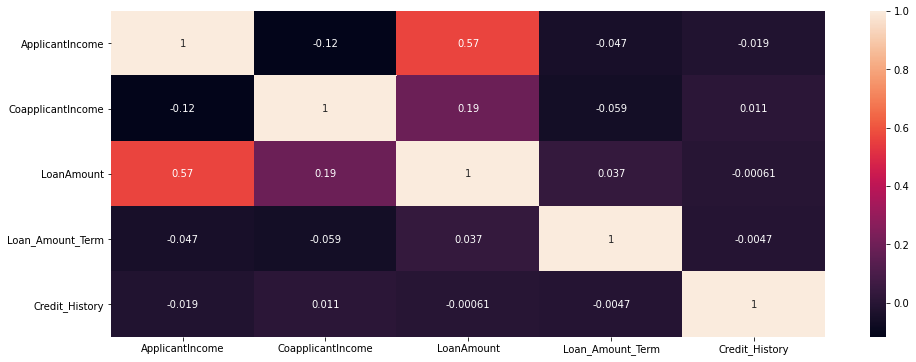

In [ ]:
# Corelation
plt.figure(figsize=(16, 6))
sns.heatmap(loan_dataset.corr(), annot=True)

In [ ]:
data = loan_dataset.copy()

In [ ]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [ ]:
Discrete_features = [x for x in Discrete_features if x != "Loan_Amount_Term"]
Continous_features = Continous_features + ["Loan_Amount_Term"]
Categorical_features + Discrete_features

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status',
 'Credit_History']

Data Preprocessing

In [ ]:
# Convert Categorical Columns
def convert_cetegorical_value(df, column):
  replace_value = {}

  for i in range(df[column].nunique()):
    replace_value[df[column].unique()[i]] = i

  df[column] = df[column].replace(replace_value).astype("uint8")
  return df, (replace_value, df[column].nunique())

In [ ]:

categorial_column_replace = {}
for feature in Categorical_features + Discrete_features:
  data, replace_value= convert_cetegorical_value(data, feature)
  categorial_column_replace[feature] = replace_value

preprocessing_tools["one_hot_replace"] = categorial_column_replace

In [ ]:
preprocessing_tools["one_hot_replace"]

{'Credit_History': ({0.0: 1, 1.0: 0}, 2),
 'Dependents': ({'0': 0, '1': 1, '2': 2, '3+': 3}, 4),
 'Education': ({'Graduate': 0, 'Not Graduate': 1}, 2),
 'Gender': ({'Female': 1, 'Male': 0}, 2),
 'Loan_Status': ({'N': 1, 'Y': 0}, 2),
 'Married': ({'No': 0, 'Yes': 1}, 2),
 'Property_Area': ({'Rural': 1, 'Semiurban': 2, 'Urban': 0}, 3),
 'Self_Employed': ({'No': 0, 'Yes': 1}, 2)}

In [ ]:
def onehot_encode(df, column, depth):
    df = df.copy()
    
    for i in range(depth):
      df[column + "_" + str(i)] = (df[column] == i).astype("uint8")
    
    df = df.drop(column, axis=1)
    return df

In [ ]:
for feature in Categorical_features + Discrete_features:
  depth = preprocessing_tools["one_hot_replace"][feature][1]
  if depth > 2:
    data = onehot_encode(data, feature, depth)

In [ ]:
data.head()

,Loan_ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3,Property_Area_0,Property_Area_1,Property_Area_2
0,LP001002,0,0,0,0,5849,0.0,128.0,360.0,0,0,1,0,0,0,1,0,0
1,LP001003,0,1,0,0,4583,1508.0,128.0,360.0,0,1,0,1,0,0,0,1,0
2,LP001005,0,1,0,1,3000,0.0,66.0,360.0,0,0,1,0,0,0,1,0,0
3,LP001006,0,1,1,0,2583,2358.0,120.0,360.0,0,0,1,0,0,0,1,0,0
4,LP001008,0,0,0,0,6000,0.0,141.0,360.0,0,0,1,0,0,0,1,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    uint8  
 2   Married            614 non-null    uint8  
 3   Education          614 non-null    uint8  
 4   Self_Employed      614 non-null    uint8  
 5   ApplicantIncome    614 non-null    int32  
 6   CoapplicantIncome  614 non-null    float32
 7   LoanAmount         614 non-null    float32
 8   Loan_Amount_Term   614 non-null    float32
 9   Credit_History     614 non-null    uint8  
 10  Loan_Status        614 non-null    uint8  
 11  Dependents_0       614 non-null    uint8  
 12  Dependents_1       614 non-null    uint8  
 13  Dependents_2       614 non-null    uint8  
 14  Dependents_3       614 non-null    uint8  
 15  Property_Area_0    614 non-null    uint8  
 16  Property_Area_1    614 non

In [ ]:
data_order = Continous_features + [x for x in data.columns.to_list() if x not in Continous_features]
data = data[data_order]
X = data.drop(columns = ["Loan_ID", "Loan_Status"])
Y = data["Loan_Status"]

X, X_test, Y, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
Continous_features, X.iloc[:,:4]

(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'],
      ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term
 356             8333             3167.0       165.0             360.0
 581             1836            33837.0        90.0             360.0
 413             2253             2033.0       110.0             360.0
 227             6250             1695.0       210.0             360.0
 415             2995                0.0        60.0             360.0
 ..               ...                ...         ...               ...
 593             3859             3300.0       142.0             180.0
 232             3189             2598.0       120.0             360.0
 154             3254                0.0        50.0             360.0
 513             2130             6666.0        70.0             180.0
 230             2491             2054.0       104.0             360.0
 
 [491 rows x 4 columns])

In [ ]:
scaler = StandardScaler()
scaler.fit(X.iloc[:,:4])


X.iloc[:,:4] = scaler.transform(X.iloc[:,:4])



In [ ]:
#using logistic regression model
classifier_logistic = LogisticRegression()
classifier_logistic.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# using svm
classifier_svm = svm.SVC()
classifier_svm.fit(X, Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
classifier_nn = keras.Sequential([
                                  keras.layers.Dense(3),
                                  keras.layers.Dense(3),
                                  keras.layers.Dense(1),
                                  keras.layers.Activation("sigmoid")
])

In [ ]:
classifier_nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
classifier_nn.fit(X, Y, epochs=50)

Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.6603 - acc: 0.6314
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6477 - acc: 0.6517
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6369 - acc: 0.6619
Epoch 4/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6289 - acc: 0.6701
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6219 - acc: 0.6802
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.6164 - acc: 0.6843
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6115 - acc: 0.6904
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6079 - acc: 0.6904
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6049 - acc: 0.6925
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.6016 - acc: 0.6925
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - lo

In [ ]:
X_test.iloc[:, :4] = scaler.transform(X_test.iloc[:, :4])

{
    "train" : {
        "nn_acc" : accuracy_score(Y, classifier_nn.predict(X) > 0.5),
        "logistic_regression_acc": accuracy_score(Y, classifier_logistic.predict(X) > 0.5),
        "svm_acc" : accuracy_score(Y, classifier_svm.predict(X) > 0.5),
    },
    "test" : {
        "nn_acc" : accuracy_score(y_test, classifier_nn.predict(X_test) > 0.5),
        "logistic_regression_acc": accuracy_score(y_test, classifier_logistic.predict(X_test)),
        "svm_acc" : accuracy_score(y_test, classifier_svm.predict(X_test)),
    }
}


{'test': {'logistic_regression_acc': 0.7967479674796748,
  'nn_acc': 0.7804878048780488,
  'svm_acc': 0.7886178861788617},
 'train': {'logistic_regression_acc': 0.8167006109979633,
  'nn_acc': 0.8167006109979633,
  'svm_acc': 0.835030549898167}}

In [ ]:
print("Train Accuracy: ", loreg.score(X, Y) * 100,' %')

Train Accuracy:  81.67006109979633  %


Logistic Regression can be best